In [78]:
import pandas as pd
import csv

from bs4 import BeautifulSoup
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [46]:
end_use_list = ['Heating', 'Cooling', 'Interior Lighting', 
                'Interior Equipment', 'Fans', 'Total End Uses']
# query monthly end-use energy consumption 
case_list = ['Baseline', 'CoolRoof_1', 'CoolRoof_2', 'CoolWall_1', 'CoolWall_2', 
             'InsRoof_1', 'InsRoof_2', 'InsWall_1', 'InsWall_2', 
             'LowEWin_1', 'LowEWin_2', 'SolarWin_1', 'SolarWin_2']
results_sum = []
for case_name, case_id in zip(case_list, range(1,14)):
    print('Start the processing of case id: '.format(case_id))
    with open("../output_files/init_{}.htm".format(case_id), encoding="utf-8") as f:
        data = f.read()
        soup = BeautifulSoup(data, 'html.parser')

        results = {}
        results['location'] = 'JAKARTA'
        results['case_id'] = case_id
        results['floor_area'] = floor_area
        
        # parse the floor area
        floor_area = 0
        i, j = 0, 0

        table = soup.find_all('table')[2]

        for row in table.find_all('tr'):
            cols = row.find_all('td')    
            for col in cols:
                i+=1
                col_text = col.get_text()
        #         print(col_text)
                if 'Net Conditioned Building Area' in col_text:
                    j = i+1
                if i == j:
                    floor_area += float(col_text)

        heating, cooling, lighting, equipment, fan = 0, 0, 0, 0, 0
        i, j = 0, 0
        table_list = soup.find_all('table')
        table_num=3
        table = soup.find_all('table')[table_num]
        for end_use in end_use_list:
            results = {}
            results['location'] = 'JAKARTA'
            results['case_name'] = case_name
            results['case_id'] = case_id
            results['floor_area'] = floor_area
            for row in table.find_all('tr'):
                cols = row.find_all('td')    
                for col in cols:
                    i+=1
                    col_text = col.get_text()
                    # print(col_text)
                    # mark the row number of the cooling coil
                    if end_use == col_text:
                        j = i+1
                    if i == j:
                        # print(col_text)
                        results['end_use'] = end_use
                        results['Electricity [kWh]'] = float(col_text)
                        print(results)
            results_sum.append(results)

    

Start the processing of case id: 
{'location': 'JAKARTA', 'case_name': 'Baseline', 'case_id': 1, 'floor_area': 28.76, 'end_use': 'Heating', 'Electricity [kWh]': 0.0}
{'location': 'JAKARTA', 'case_name': 'Baseline', 'case_id': 1, 'floor_area': 28.76, 'end_use': 'Cooling', 'Electricity [kWh]': 423.69}
{'location': 'JAKARTA', 'case_name': 'Baseline', 'case_id': 1, 'floor_area': 28.76, 'end_use': 'Interior Lighting', 'Electricity [kWh]': 501.28}
{'location': 'JAKARTA', 'case_name': 'Baseline', 'case_id': 1, 'floor_area': 28.76, 'end_use': 'Interior Equipment', 'Electricity [kWh]': 2176.06}
{'location': 'JAKARTA', 'case_name': 'Baseline', 'case_id': 1, 'floor_area': 28.76, 'end_use': 'Fans', 'Electricity [kWh]': 28.15}
{'location': 'JAKARTA', 'case_name': 'Baseline', 'case_id': 1, 'floor_area': 28.76, 'end_use': 'Total End Uses', 'Electricity [kWh]': 3129.18}
Start the processing of case id: 
{'location': 'JAKARTA', 'case_name': 'CoolRoof_1', 'case_id': 2, 'floor_area': 28.76, 'end_use': 'H

In [47]:
keys = results_sum[0].keys()
with open('IDN_Res_JAKARTA_Summary.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(results_sum)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os

In [6]:
# Step 1: Parse all CSV files in a folder and append them into a single dataframe

folder_path = os.getcwd()  # Replace with the path to your folder
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

df_list = []

for file in all_files:
    file_path = os.path.join(folder_path, file)
    temp_df = pd.read_csv(file_path)
    df_list.append(temp_df)

# Concatenate all dataframes in the list into a single dataframe
df = pd.concat(df_list, ignore_index=True)

# Step 2: Melt the dataframe



In [16]:
# Assuming you want to melt based on a column named 'id_column' and transform 'variable_column' into multiple columns
pivot_df = df.pivot_table(index=['location', 'orientation', 'ac_scenario', 'case_name'], 
                          columns='end_use', values='Electricity [kWh]', aggfunc='sum').reset_index()
pivot_df['hvac'] = pivot_df['Cooling'] + pivot_df['Heating'] + pivot_df['Fans']

In [18]:
pivot_df.to_csv('IDN_Res_Summary.csv', index=False)

In [29]:
df2 = pd.DataFrame()
for location in pivot_df['location'].unique():
    for orientation in pivot_df['orientation'].unique():
        for ac_scenario in pivot_df['ac_scenario'].unique():
            sub_df = pivot_df[(pivot_df['location']==location) & (pivot_df['orientation']==orientation) & (pivot_df['ac_scenario']==ac_scenario)]
            sub_df = sub_df.pivot(index=['location','orientation','ac_scenario'], 
                                  columns='case_name', values='hvac').reset_index()
            # Calculate the savings for each scenario compared to the baseline
            for column in sub_df.columns[3::]:
                if column != 'Baseline':
                    sub_df[f'{column}_savings_kwh'] = sub_df['Baseline'] - sub_df[column]
                    sub_df[f'{column}_savings_pct'] = sub_df[f'{column}_savings_kwh']/sub_df['Baseline']
                else:
                    sub_df[f'Baseline_savings_kwh'] = 0
                    sub_df[f'Baseline_savings_pct'] = 0
            df2 = pd.concat([df2, sub_df], ignore_index=True)
df2.to_csv('IDN_Res_Savings.csv', index=False)
            

In [43]:
# List of strings to search for
search_strings = ['Baseline', 'kwh', 'pct']

# Find columns that contain any of the search strings
matching_columns = [col for col in df2.columns if col.split('_')[-1] in search_strings]

# Melt the dataframe
melted_df = pd.melt(df2, id_vars=['location','orientation','ac_scenario'], 
                    value_vars=matching_columns, 
                    var_name='case_name', value_name='value')

In [ ]:
# Set the sns style
sns.set_style('darkgrid')
sns.set_context('paper')

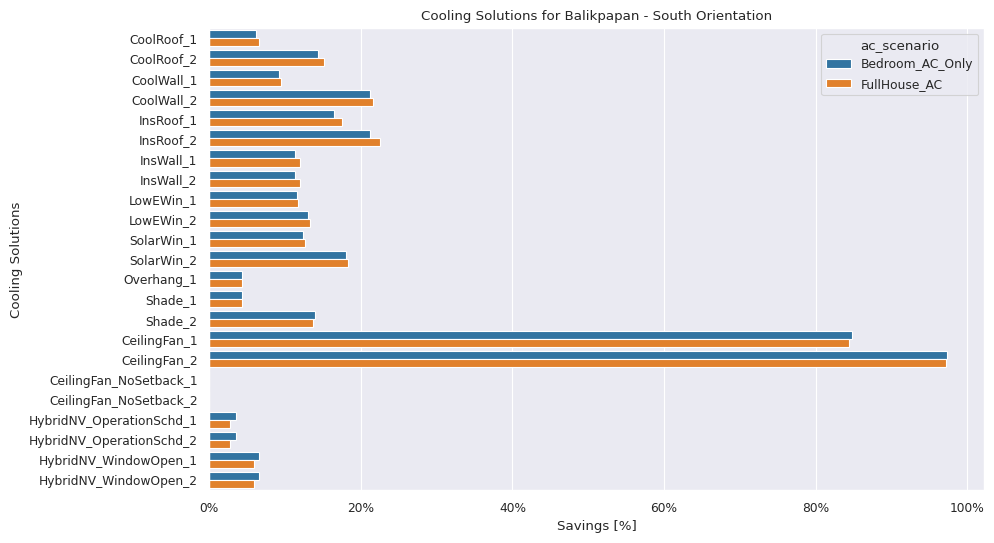

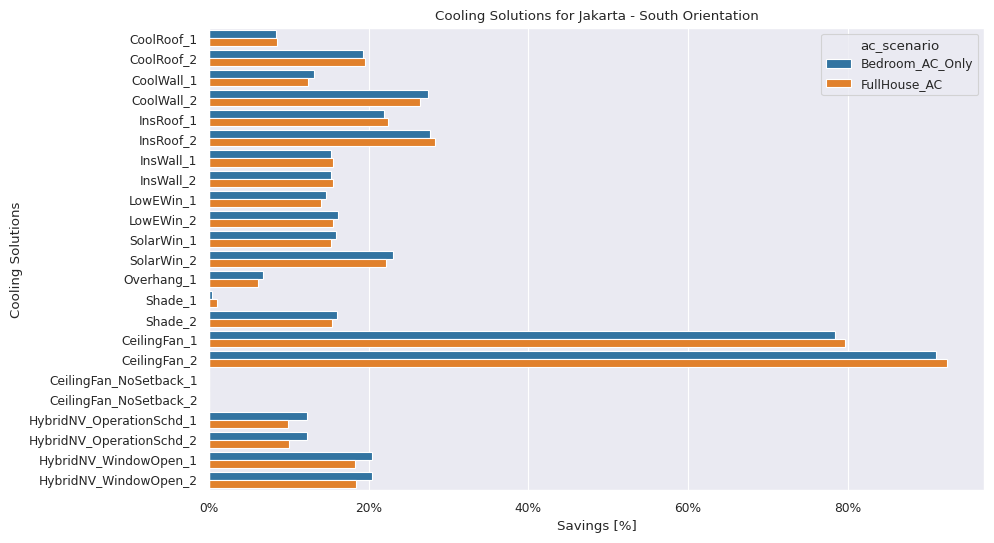

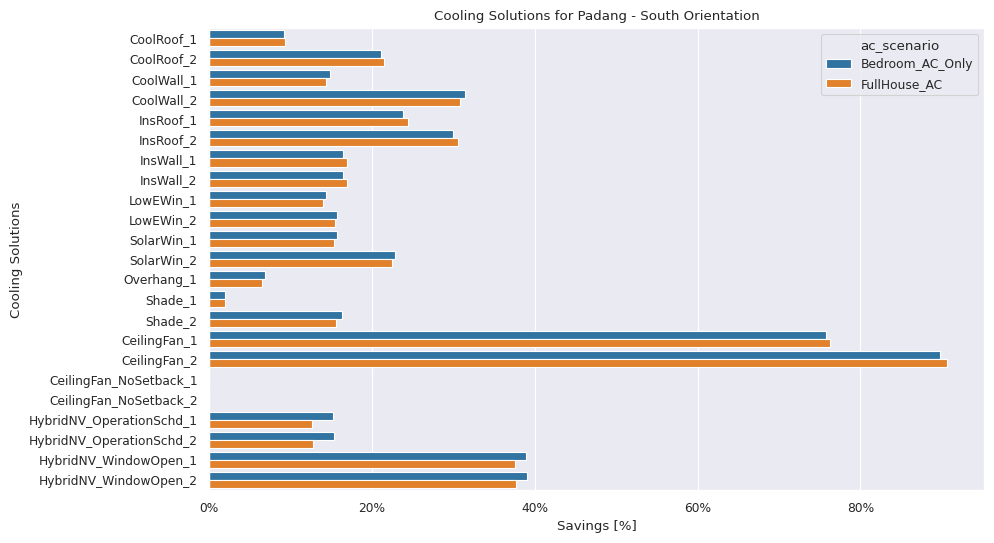

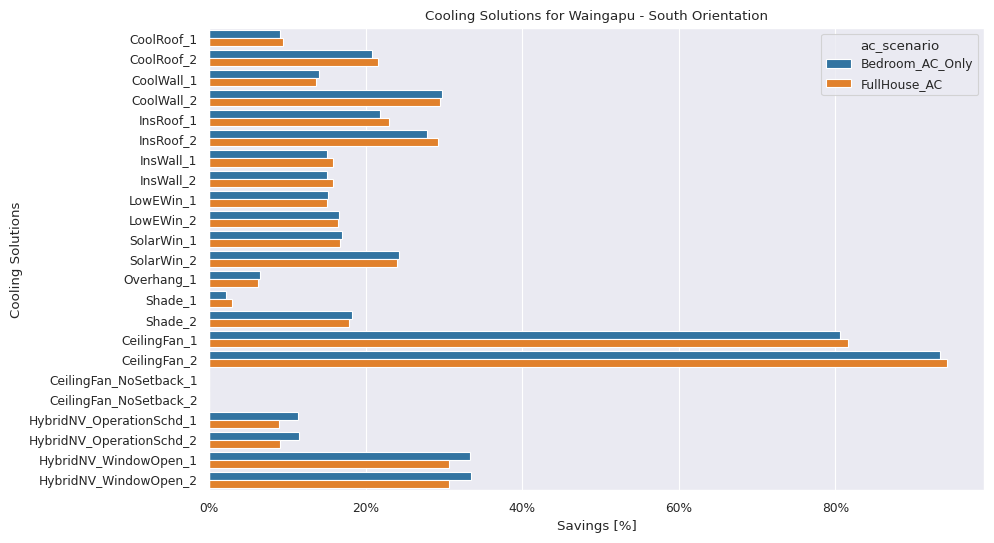

In [83]:
# Create the figure: south orientation, bedroom ac only vs full ac, pct savings
cooling_solution_shortlist = ['CoolRoof_1', 'CoolRoof_2', 
                         'CoolWall_1', 'CoolWall_2',
                         'InsRoof_1', 'InsRoof_2', 
                         'InsWall_1', 'InsWall_2', 
                         'LowEWin_1', 'LowEWin_2', 
                         'SolarWin_1', 'SolarWin_2',
                         'Overhang_1',
                         'Shade_1', 'Shade_2',
                         'CeilingFan_1','CeilingFan_2', 
                         'CeilingFan_NoSetback_1', 'CeilingFan_NoSetback_2', 
                         'HybridNV_OperationSchd_1', 'HybridNV_OperationSchd_2',
                         'HybridNV_WindowOpen_1', 'HybridNV_WindowOpen_2']

cooling_solution_list = ['CoolRoof_1_savings_pct', 'CoolRoof_2_savings_pct', 
                         'CoolWall_1_savings_pct', 'CoolWall_2_savings_pct',
                         'InsRoof_1_savings_pct', 'InsRoof_2_savings_pct', 
                         'InsWall_1_savings_pct', 'InsWall_2_savings_pct', 
                         'LowEWin_1_savings_pct', 'LowEWin_2_savings_pct', 
                         'SolarWin_1_savings_pct', 'SolarWin_2_savings_pct',
                         'Overhang_1_savings_pct',
                         'Shade_1_savings_pct', 'Shade_2_savings_pct',
                         'CeilingFan_1_savings_pct','CeilingFan_2_savings_pct', 
                         'CeilingFan_NoSetback_1_savings_pct', 'CeilingFan_NoSetback_2_savings_pct', 
                         'HybridNV_OperationSchd_1_savings_pct', 'HybridNV_OperationSchd_2_savings_pct',
                         'HybridNV_WindowOpen_1_savings_pct', 'HybridNV_WindowOpen_2_savings_pct']
# Create a subset of the dataframe for plotting
for location in melted_df['location'].unique():
    plot_df = melted_df.loc[(melted_df['location']==location) & (melted_df['orientation']=='South') & (melted_df['ac_scenario'].isin(['Bedroom_AC_Only', 'FullHouse_AC'])) & (melted_df['case_name'].isin(cooling_solution_list))].copy()
    plot_df['case_name_short'] = plot_df['case_name'].str.split('_').str[:-2].str.join('_')
    plot_df['pct_savings'] = plot_df['value']*100
    # Create the plot
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6),facecolor='w', edgecolor='k',
                            sharey=False, sharex=False)
    fig.subplots_adjust(hspace=.1, wspace=.1)
    sns.barplot(data=plot_df, y='case_name_short', x='pct_savings', orient="h", order=cooling_solution_shortlist, 
                hue='ac_scenario', ax=ax1)

    # Formatting the plot
    ax1.set_title('Cooling Solutions for {} - South Orientation'.format(location))
    ax1.set_ylabel('Cooling Solutions')
    ax1.set_xlabel('Savings [%]')
    ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

    fig.savefig('plot/pct_savings_{}.png'.format(location), dpi=300, format='png', bbox_inches='tight')

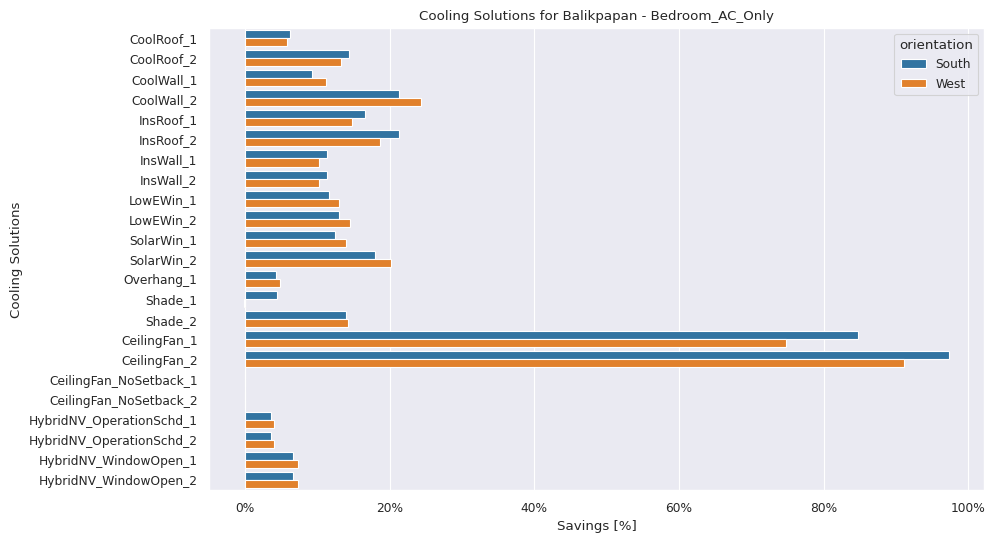

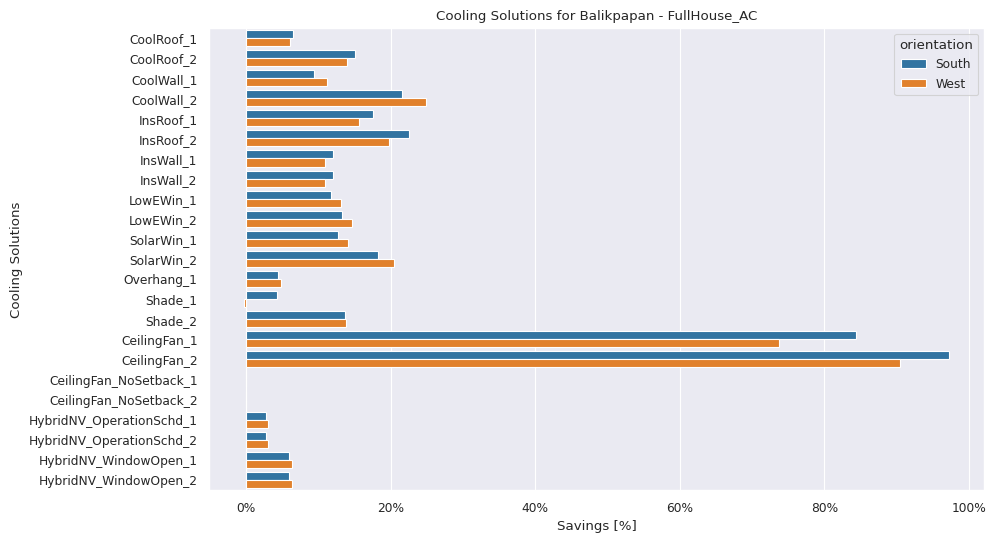

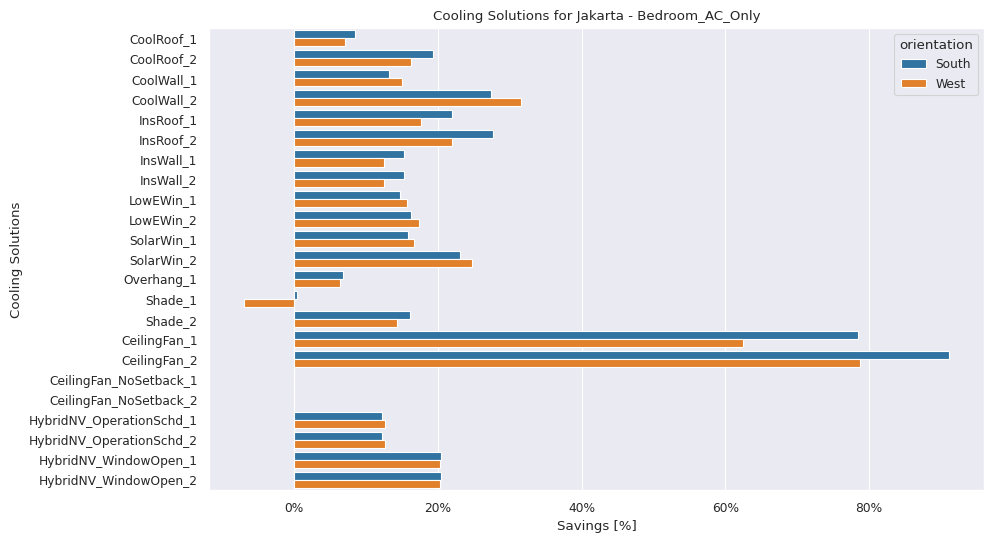

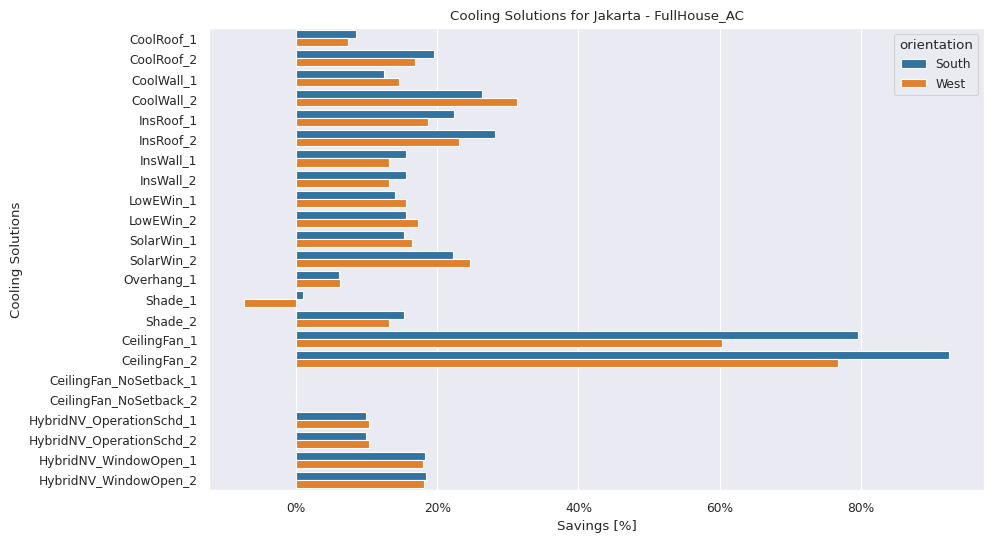

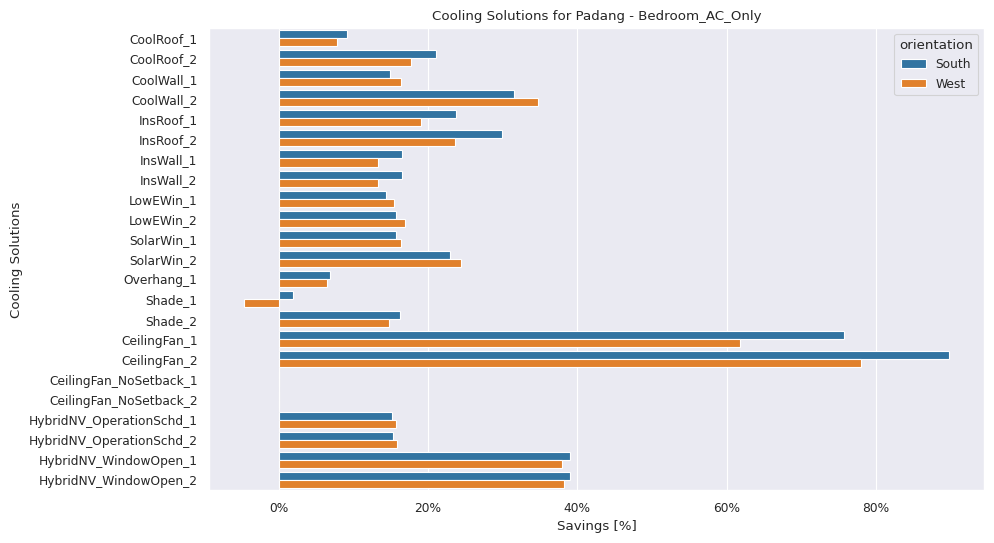

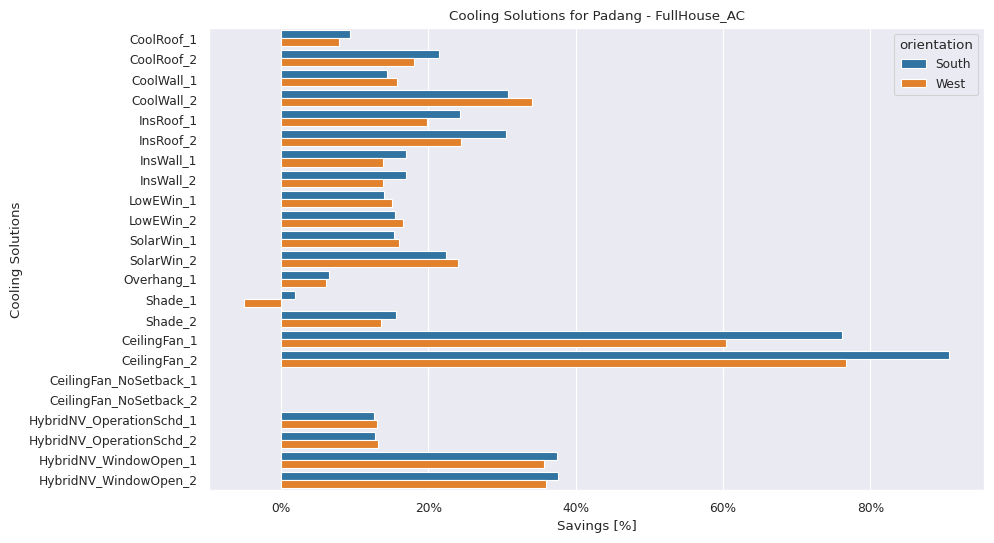

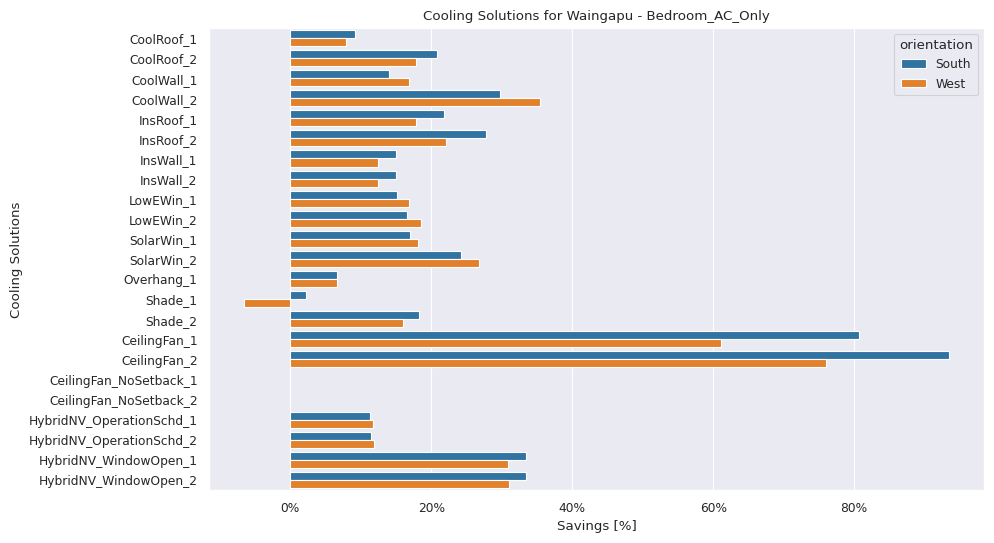

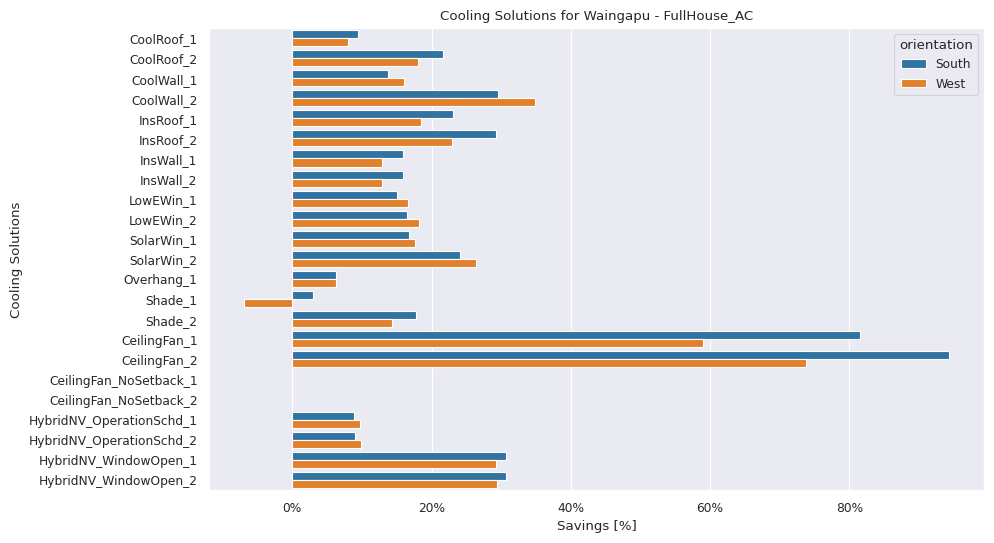

In [86]:
# Create the figure: south vs. west orientation, bedroom ac only, pct savings
# Create a subset of the dataframe for plotting
for location in melted_df['location'].unique():
    for ac_scenario in ['Bedroom_AC_Only', 'FullHouse_AC']:
        plot_df = melted_df.loc[(melted_df['location']==location) & (melted_df['ac_scenario'].isin([ac_scenario])) & (melted_df['case_name'].isin(cooling_solution_list))].copy()
        plot_df['case_name_short'] = plot_df['case_name'].str.split('_').str[:-2].str.join('_')
        plot_df['pct_savings'] = plot_df['value']*100
        # Create the plot
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6),facecolor='w', edgecolor='k',
                                sharey=False, sharex=False)
        fig.subplots_adjust(hspace=.1, wspace=.1)
        sns.barplot(data=plot_df, y='case_name_short', x='pct_savings', orient="h", order=cooling_solution_shortlist, 
                    hue='orientation', ax=ax1)

        # Formatting the plot
        ax1.set_title('Cooling Solutions for {} - {}'.format(location, ac_scenario))
        ax1.set_ylabel('Cooling Solutions')
        ax1.set_xlabel('Savings [%]')
        ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

        fig.savefig('plot/pct_savings_{}_{}.png'.format(location, ac_scenario), 
                    dpi=300, format='png', bbox_inches='tight')

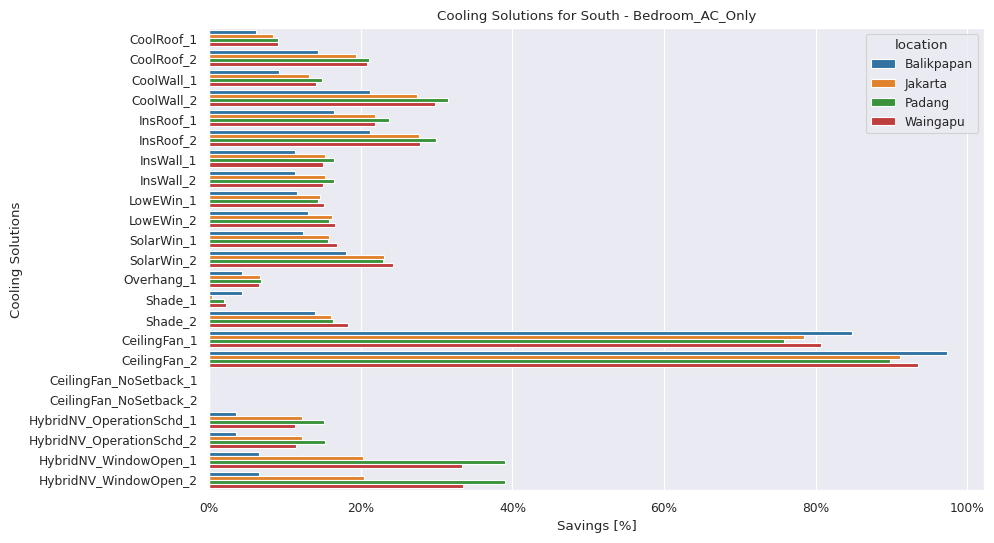

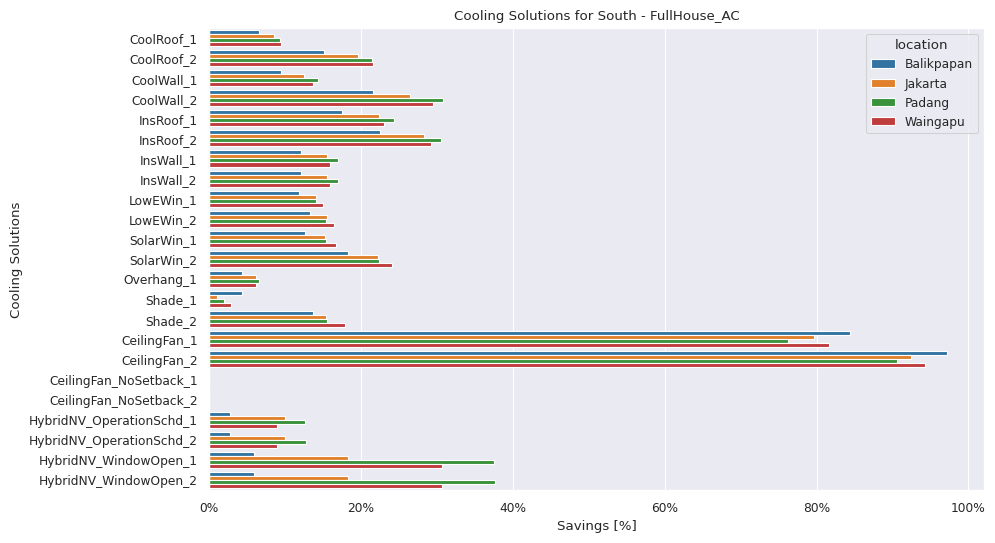

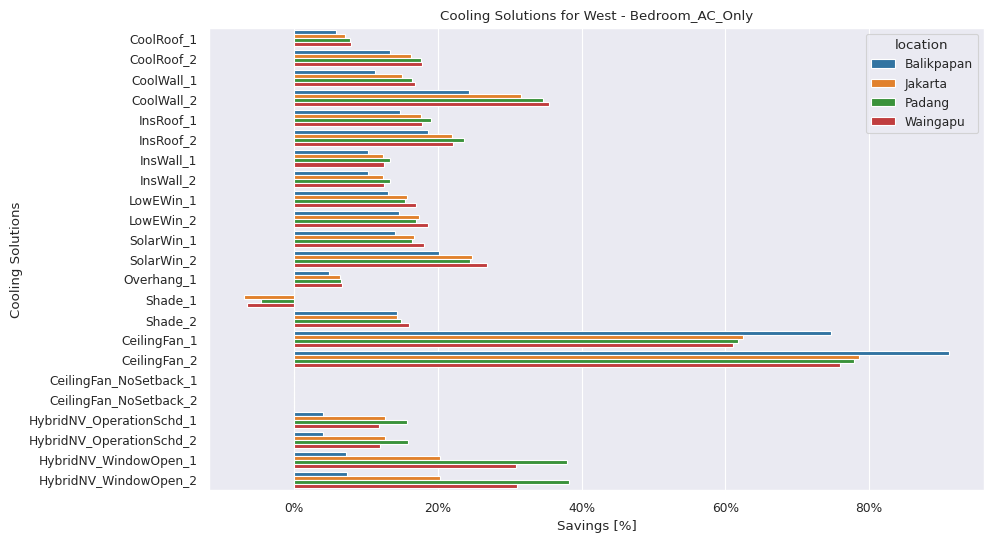

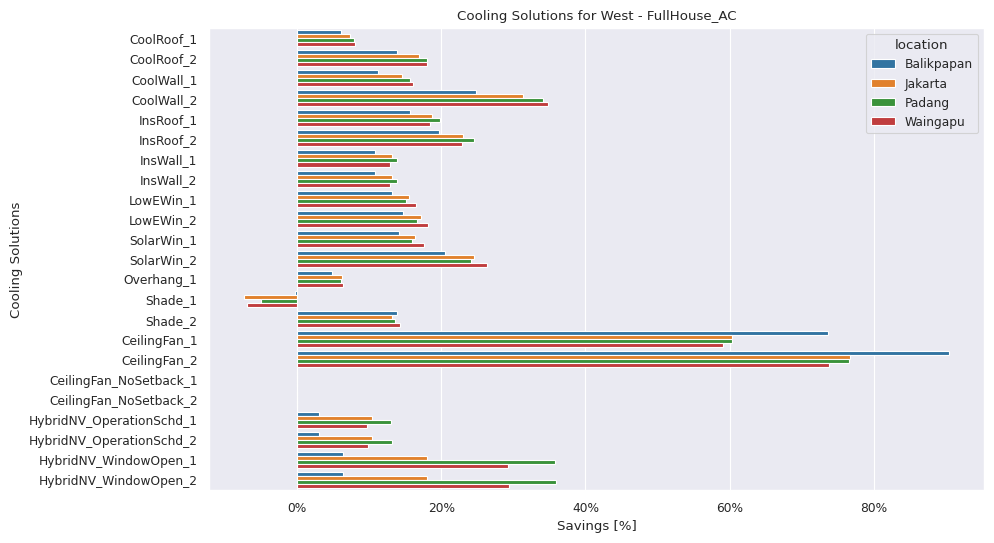

In [88]:
# Create the figure: south orientation, bedroom ac only, pct savings comparison between locations
# Create a subset of the dataframe for plotting
for orientation in melted_df['orientation'].unique():
    for ac_scenario in ['Bedroom_AC_Only', 'FullHouse_AC']:
        plot_df = melted_df.loc[(melted_df['orientation']==orientation) & (melted_df['ac_scenario'].isin([ac_scenario])) & (melted_df['case_name'].isin(cooling_solution_list))].copy()
        plot_df['case_name_short'] = plot_df['case_name'].str.split('_').str[:-2].str.join('_')
        plot_df['pct_savings'] = plot_df['value']*100
        # Create the plot
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6),facecolor='w', edgecolor='k',
                                sharey=False, sharex=False)
        fig.subplots_adjust(hspace=.1, wspace=.1)
        sns.barplot(data=plot_df, y='case_name_short', x='pct_savings', orient="h", order=cooling_solution_shortlist, 
                    hue='location', ax=ax1)

        # Formatting the plot
        ax1.set_title('Cooling Solutions for {} - {}'.format(orientation, ac_scenario))
        ax1.set_ylabel('Cooling Solutions')
        ax1.set_xlabel('Savings [%]')
        ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

        fig.savefig('plot/pct_savings_{}_{}.png'.format(orientation, ac_scenario), 
                    dpi=300, format='png', bbox_inches='tight')

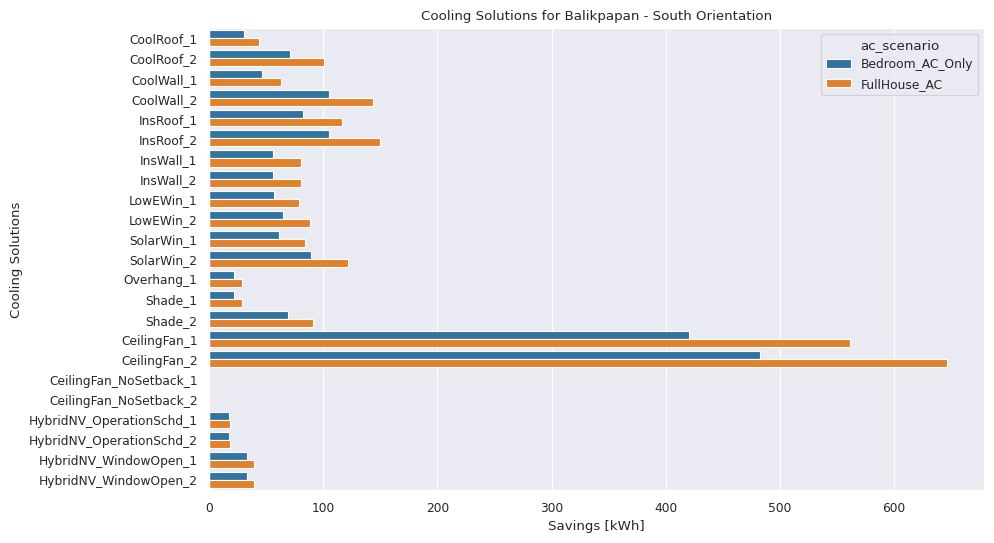

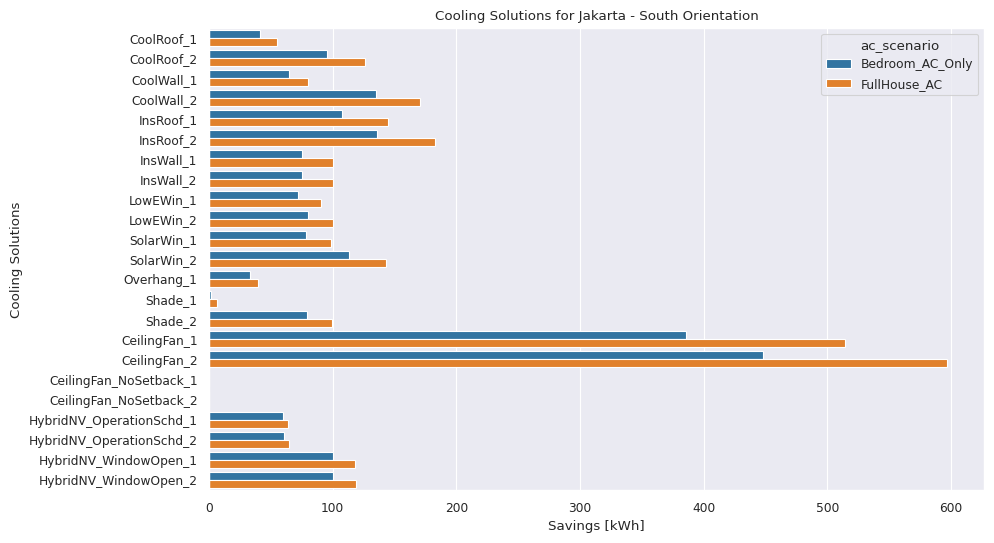

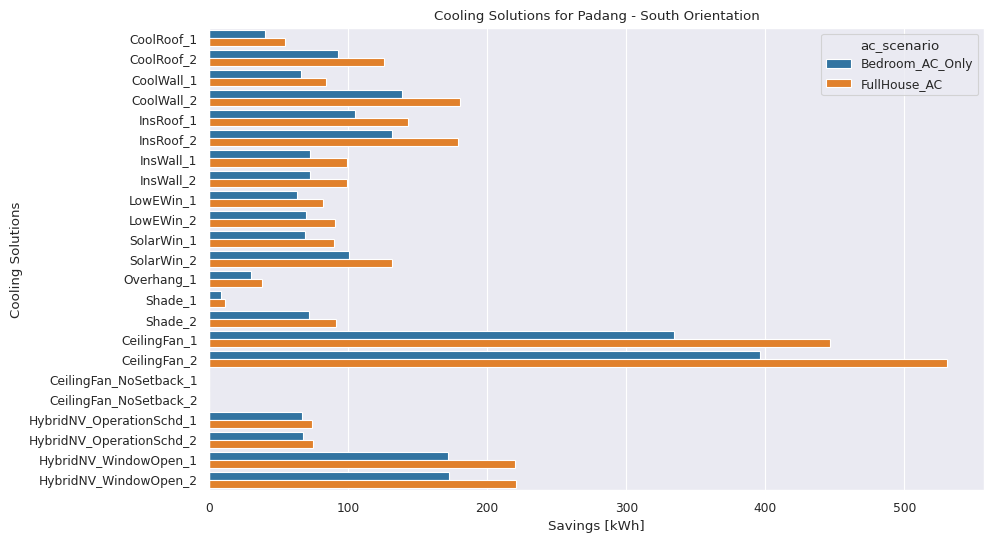

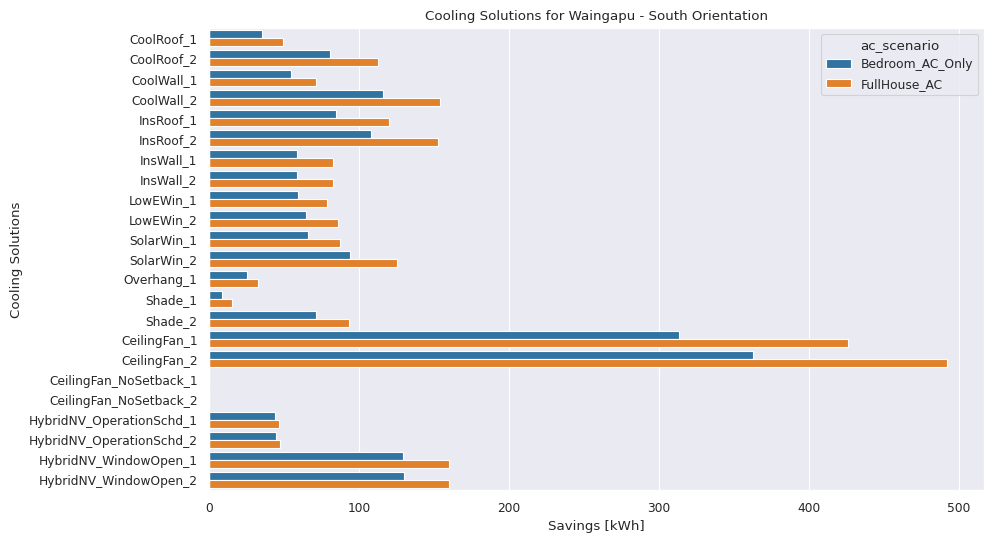

In [91]:
## Create absolute savings plots
# Create the figure: south orientation, bedroom ac only vs full ac, pct savings
cooling_solution_shortlist = ['CoolRoof_1', 'CoolRoof_2', 
                         'CoolWall_1', 'CoolWall_2',
                         'InsRoof_1', 'InsRoof_2', 
                         'InsWall_1', 'InsWall_2', 
                         'LowEWin_1', 'LowEWin_2', 
                         'SolarWin_1', 'SolarWin_2',
                         'Overhang_1',
                         'Shade_1', 'Shade_2',
                         'CeilingFan_1','CeilingFan_2', 
                         'CeilingFan_NoSetback_1', 'CeilingFan_NoSetback_2', 
                         'HybridNV_OperationSchd_1', 'HybridNV_OperationSchd_2',
                         'HybridNV_WindowOpen_1', 'HybridNV_WindowOpen_2']

cooling_solution_list = ['CoolRoof_1_savings_kwh', 'CoolRoof_2_savings_kwh', 
                         'CoolWall_1_savings_kwh', 'CoolWall_2_savings_kwh',
                         'InsRoof_1_savings_kwh', 'InsRoof_2_savings_kwh', 
                         'InsWall_1_savings_kwh', 'InsWall_2_savings_kwh', 
                         'LowEWin_1_savings_kwh', 'LowEWin_2_savings_kwh', 
                         'SolarWin_1_savings_kwh', 'SolarWin_2_savings_kwh',
                         'Overhang_1_savings_kwh',
                         'Shade_1_savings_kwh', 'Shade_2_savings_kwh',
                         'CeilingFan_1_savings_kwh','CeilingFan_2_savings_kwh', 
                         'CeilingFan_NoSetback_1_savings_kwh', 'CeilingFan_NoSetback_2_savings_kwh', 
                         'HybridNV_OperationSchd_1_savings_kwh', 'HybridNV_OperationSchd_2_savings_kwh',
                         'HybridNV_WindowOpen_1_savings_kwh', 'HybridNV_WindowOpen_2_savings_kwh']
# Create a subset of the dataframe for plotting
for location in melted_df['location'].unique():
    plot_df = melted_df.loc[(melted_df['location']==location) & (melted_df['orientation']=='South') & (melted_df['ac_scenario'].isin(['Bedroom_AC_Only', 'FullHouse_AC'])) & (melted_df['case_name'].isin(cooling_solution_list))].copy()
    plot_df['case_name_short'] = plot_df['case_name'].str.split('_').str[:-2].str.join('_')
    # Create the plot
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6),facecolor='w', edgecolor='k',
                            sharey=False, sharex=False)
    fig.subplots_adjust(hspace=.1, wspace=.1)
    sns.barplot(data=plot_df, y='case_name_short', x='value', orient="h", order=cooling_solution_shortlist, 
                hue='ac_scenario', ax=ax1)

    # Formatting the plot
    ax1.set_title('Cooling Solutions for {} - South Orientation'.format(location))
    ax1.set_ylabel('Cooling Solutions')
    ax1.set_xlabel('Savings [kWh]')
    # ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

    fig.savefig('plot/kwh_savings_{}.png'.format(location), dpi=300, format='png', bbox_inches='tight')

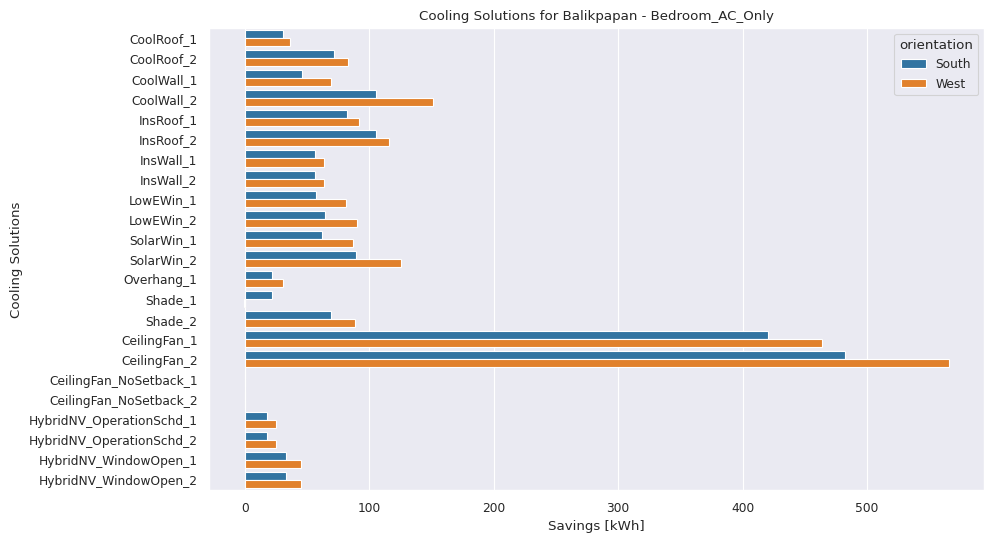

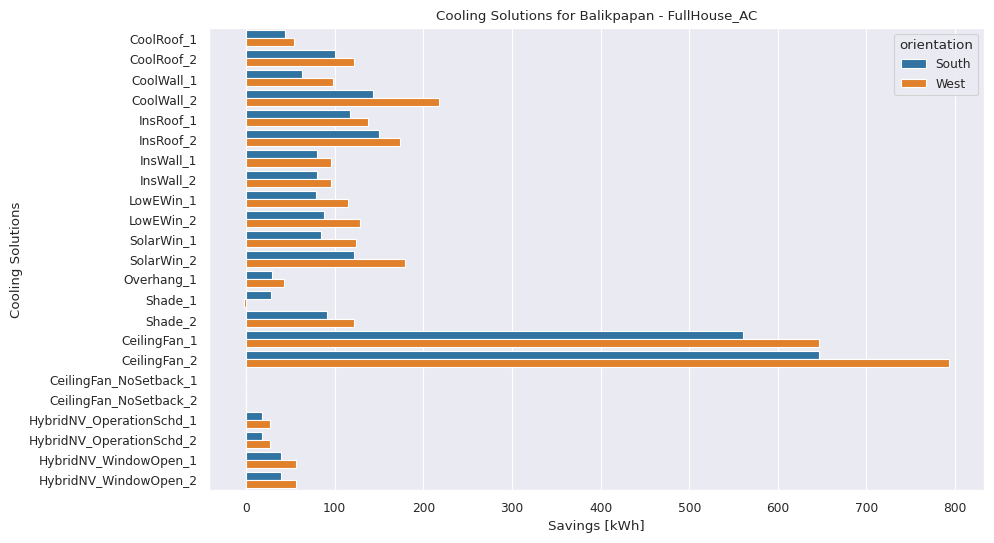

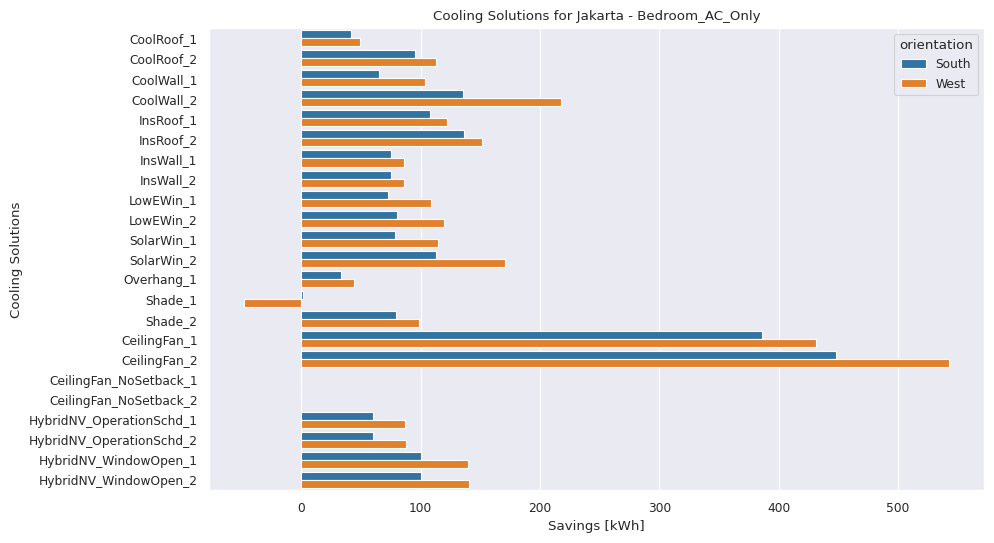

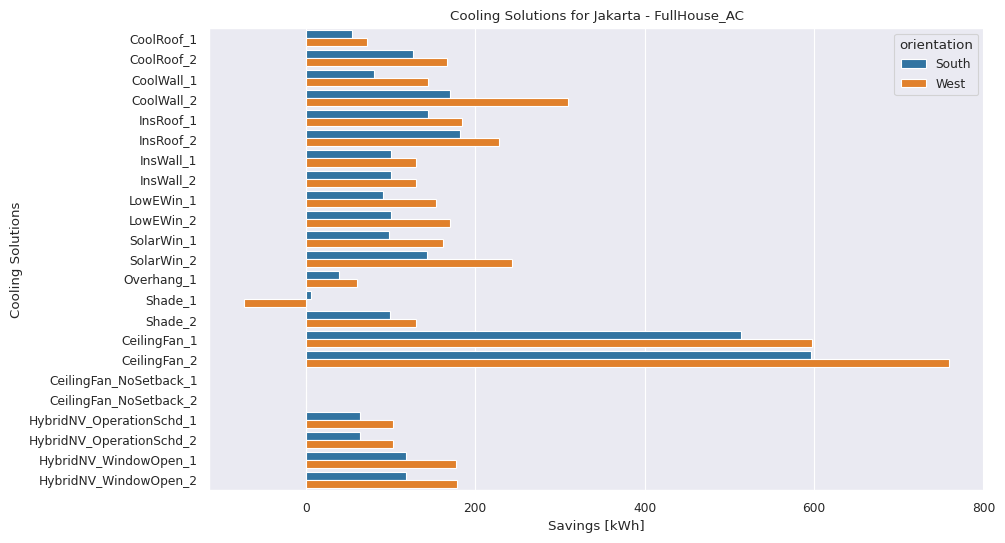

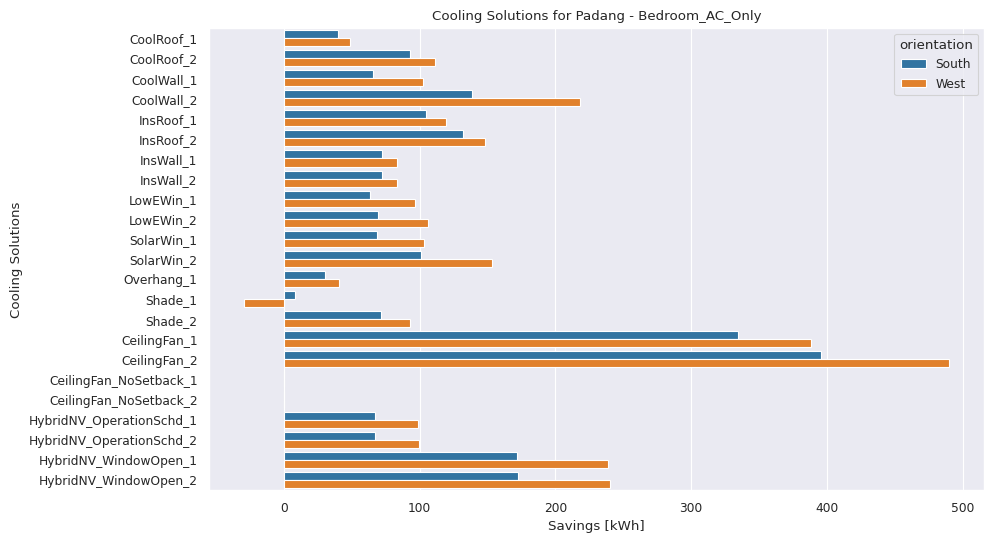

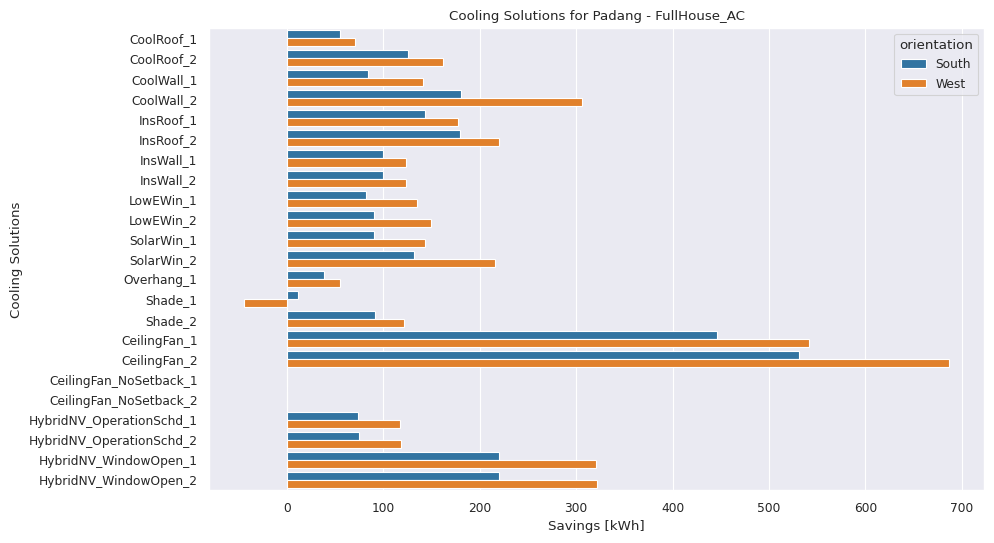

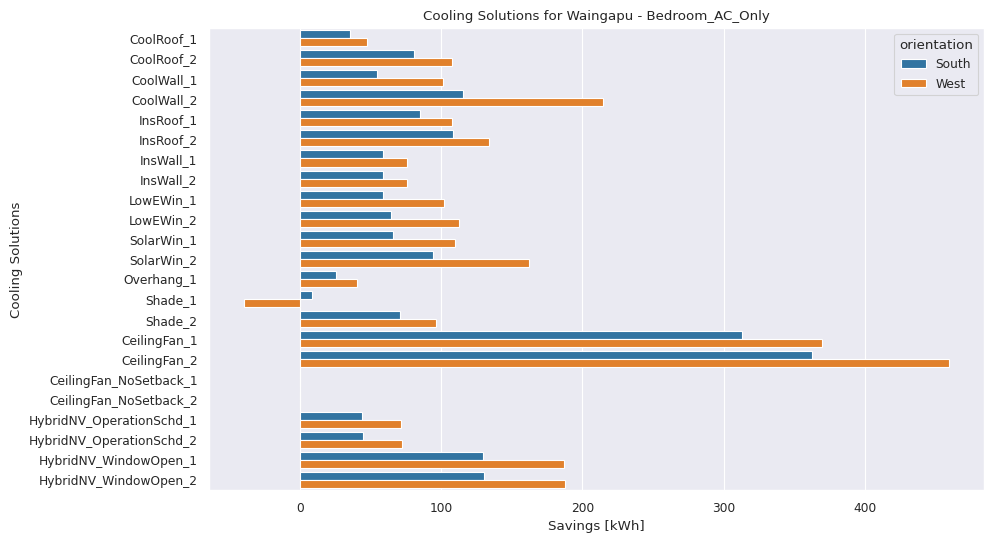

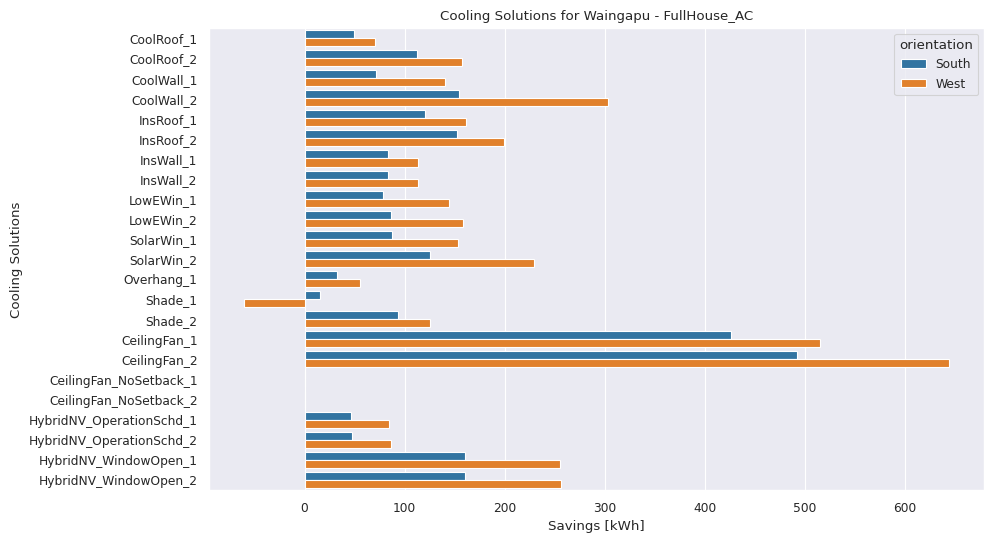

In [92]:
# Create the figure: south vs. west orientation, bedroom ac only, kwh savings
for location in melted_df['location'].unique():
    for ac_scenario in ['Bedroom_AC_Only', 'FullHouse_AC']:
        plot_df = melted_df.loc[(melted_df['location']==location) & (melted_df['ac_scenario'].isin([ac_scenario])) & (melted_df['case_name'].isin(cooling_solution_list))].copy()
        plot_df['case_name_short'] = plot_df['case_name'].str.split('_').str[:-2].str.join('_')
        # Create the plot
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6),facecolor='w', edgecolor='k',
                                sharey=False, sharex=False)
        fig.subplots_adjust(hspace=.1, wspace=.1)
        sns.barplot(data=plot_df, y='case_name_short', x='value', orient="h", order=cooling_solution_shortlist, 
                    hue='orientation', ax=ax1)

        # Formatting the plot
        ax1.set_title('Cooling Solutions for {} - {}'.format(location, ac_scenario))
        ax1.set_ylabel('Cooling Solutions')
        ax1.set_xlabel('Savings [kWh]')
        # ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

        fig.savefig('plot/kwh_savings_{}_{}.png'.format(location, ac_scenario), 
                    dpi=300, format='png', bbox_inches='tight')

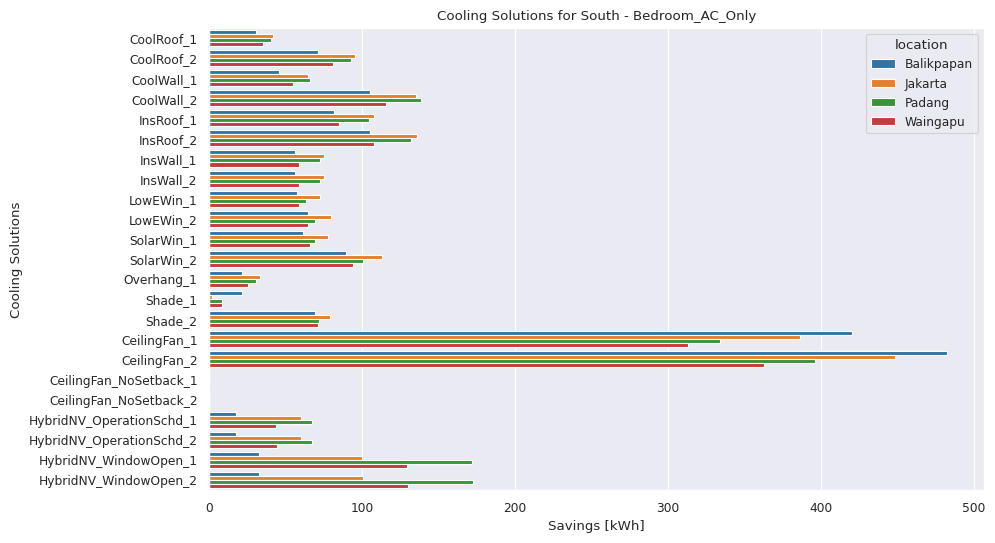

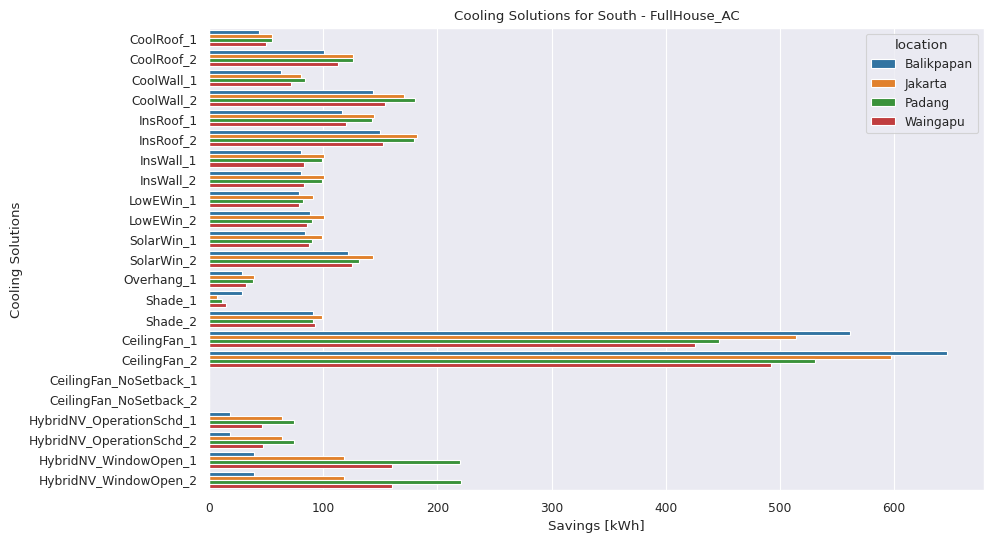

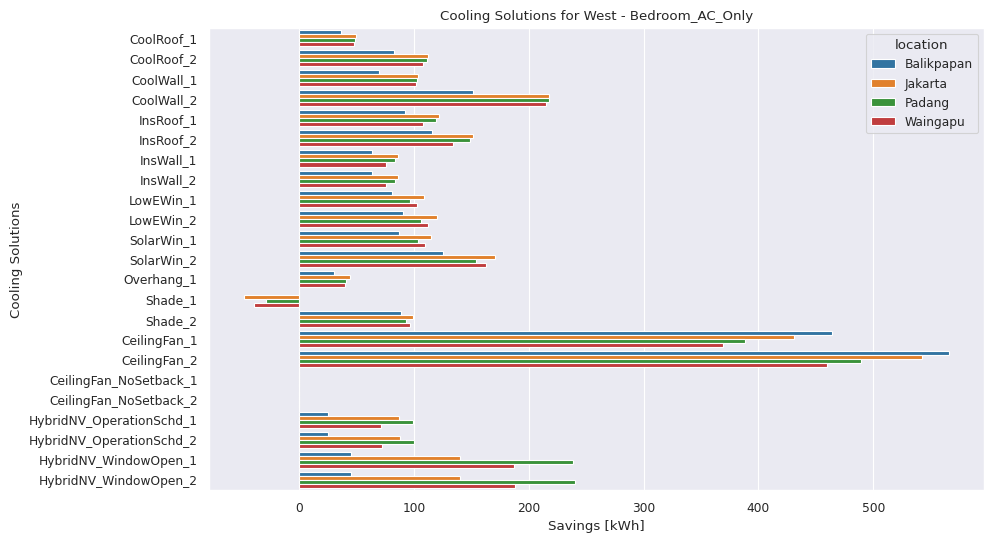

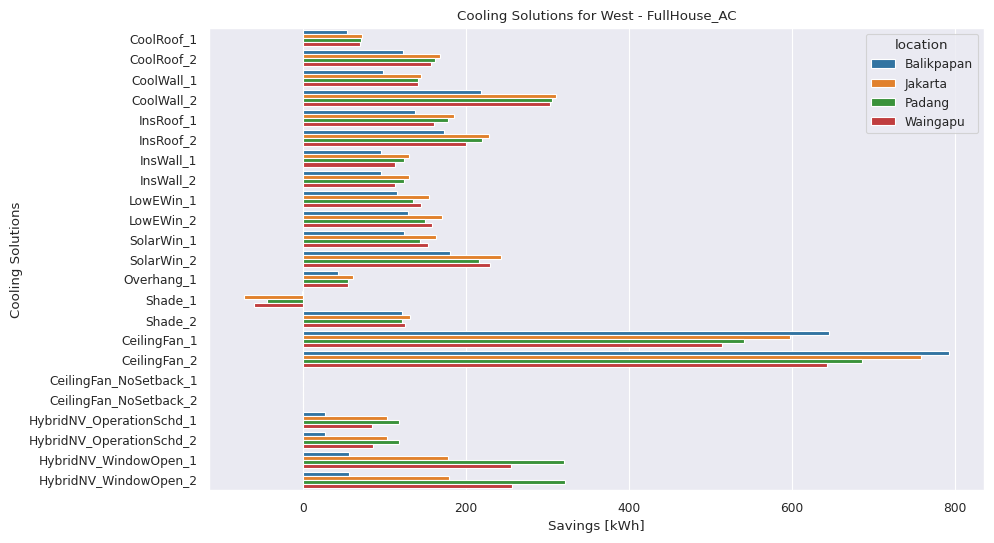

In [94]:
# Create the figure: south orientation, bedroom ac only, kwh savings comparison between locations
# Create a subset of the dataframe for plotting
for orientation in melted_df['orientation'].unique():
    for ac_scenario in ['Bedroom_AC_Only', 'FullHouse_AC']:
        plot_df = melted_df.loc[(melted_df['orientation']==orientation) & (melted_df['ac_scenario'].isin([ac_scenario])) & (melted_df['case_name'].isin(cooling_solution_list))].copy()
        plot_df['case_name_short'] = plot_df['case_name'].str.split('_').str[:-2].str.join('_')
        # Create the plot
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6),facecolor='w', edgecolor='k',
                                sharey=False, sharex=False)
        fig.subplots_adjust(hspace=.1, wspace=.1)
        sns.barplot(data=plot_df, y='case_name_short', x='value', orient="h", order=cooling_solution_shortlist, 
                    hue='location', ax=ax1)

        # Formatting the plot
        ax1.set_title('Cooling Solutions for {} - {}'.format(orientation, ac_scenario))
        ax1.set_ylabel('Cooling Solutions')
        ax1.set_xlabel('Savings [kWh]')
        # ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

        fig.savefig('plot/kwh_savings_{}_{}.png'.format(orientation, ac_scenario), 
                    dpi=300, format='png', bbox_inches='tight')